In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint
from sklearn.tree import export_graphviz
from IPython.display import Image

In [31]:
df = pd.read_csv('./chatgpt1.csv')

In [32]:
df.columns

Index(['Datetime', 'Tweet Id', 'Text', 'Username', 'Permalink', 'User',
       'Outlinks', 'CountLinks', 'ReplyCount', 'RetweetCount', 'LikeCount',
       'QuoteCount', 'ConversationId', 'Language', 'Source', 'Media',
       'QuotedTweet', 'MentionedUsers', 'hashtag', 'hastag_counts'],
      dtype='object')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Datetime        50001 non-null  object
 1   Tweet Id        50001 non-null  int64 
 2   Text            50001 non-null  object
 3   Username        50001 non-null  object
 4   Permalink       50001 non-null  object
 5   User            50001 non-null  object
 6   Outlinks        19942 non-null  object
 7   CountLinks      19942 non-null  object
 8   ReplyCount      50001 non-null  int64 
 9   RetweetCount    50001 non-null  int64 
 10  LikeCount       50001 non-null  int64 
 11  QuoteCount      50001 non-null  int64 
 12  ConversationId  50001 non-null  int64 
 13  Language        50001 non-null  object
 14  Source          50001 non-null  object
 15  Media           9502 non-null   object
 16  QuotedTweet     3563 non-null   object
 17  MentionedUsers  17169 non-null  object
 18  hashta

In [34]:
df.describe()

,Tweet Id,ReplyCount,RetweetCount,LikeCount,QuoteCount,ConversationId,hastag_counts
count,5.000100e+04,50001.000000,50001.000000,50001.000000,50001.000000,5.000100e+04,50001.000000
mean,1.617493e+18,0.929141,1.498510,9.696326,0.219536,1.617205e+18,0.783304
std,1.725682e+14,23.251710,46.030058,313.524215,10.356329,1.005075e+16,1.975040
min,1.617156e+18,0.000000,0.000000,0.000000,0.000000,6.493609e+17,0.000000
25%,1.617354e+18,0.000000,0.000000,0.000000,0.000000,1.617302e+18,0.000000
50%,1.617525e+18,0.000000,0.000000,0.000000,0.000000,1.617504e+18,0.000000
75%,1.617625e+18,1.000000,0.000000,2.000000,0.000000,1.617607e+18,1.000000
max,1.617779e+18,3098.000000,6815.000000,56073.000000,1947.000000,1.617779e+18,28.000000


In [35]:
df['Username'].value_counts()

translation_ja    60
SaveToNotion      47
trandanhmmo       44
richardkimphd     43
VeilleCyber3      38
                  ..
masayume_32        1
WRoughSketch       1
ayazfarooqui       1
Technology_GD      1
AmericoSD_69       1
Name: Username, Length: 38433, dtype: int64

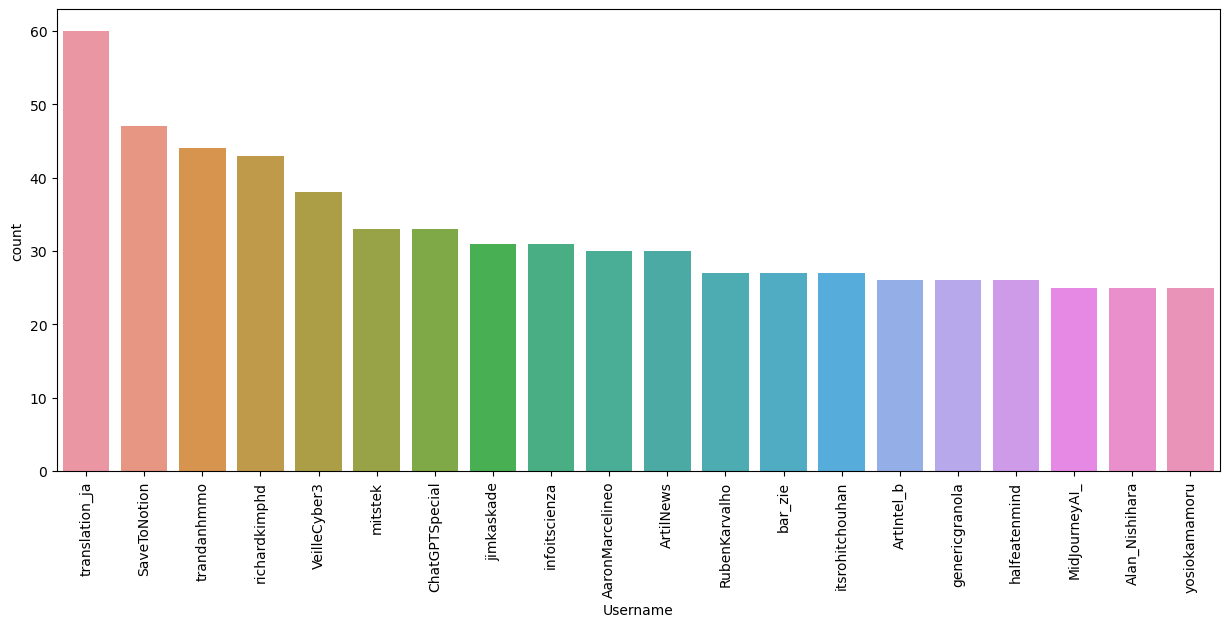

In [36]:
plt.figure(figsize=(15,6))
sns.countplot(data=df, x='Username', order=df["Username"].value_counts().index[:20])
plt.xticks(rotation=90)
plt.show()

##Cleaning Data

In [37]:
# Text Preprocessing
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text 

df['tidy_text'] = np.vectorize(remove_pattern)(df['Text'], "@[\w]*: | *RT*")
df[["Text", "tidy_text"]].head(5)

# Removing http/https
cleaned_tweets = []

for index, row in df.iterrows():
    
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tidy_text.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

df['tidy_text'] = cleaned_tweets
df[["Text", "tidy_text"]].head(10)

# removing empty text
df = df[df['tidy_text']!='']
df[["Text", "tidy_text"]].head(5)

# Removing punctuations, numbers and special characters
df['All_tidy_text'] = df['tidy_text'].str.replace("[^a-zA-Z# ]", "")

/var/folders/6p/qjy8_4c14_s30rxq1s3hxcg40000gn/T/ipykernel_1796/3905504758.py:29: FutureWarning: The default value of regex will change from True to False in a future version.
  df['All_tidy_text'] = df['tidy_text'].str.replace("[^a-zA-Z# ]", "")


SENTIMENT ANALYSIS

In [38]:
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

In [39]:
sia = SentimentIntensityAnalyzer()
def find_sentiment(post):
    try:
        if sia.polarity_scores(post)["compound"] > 0:
            return "Positive"
        elif sia.polarity_scores(post)["compound"] < 0:
            return "Negative"
        else:
            return "Neutral"  
    except:
        return "Neutral"

In [40]:
def plot_sentiment(df, feature, title):
    counts = df[feature].value_counts()
    percent = counts/sum(counts)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
    
    colors = ["green", "red", "blue"]
    counts.plot(kind='bar', ax=ax1, color=colors)
    percent.plot(kind='bar', ax=ax2, color=colors)
    ax1.set_ylabel(f'Counts : {title} sentiments', size=12)
    ax2.set_ylabel(f'Percentage : {title} sentiments', size=12)
    plt.suptitle(f"Sentiment analysis: {title}")
    plt.tight_layout()
    plt.show()

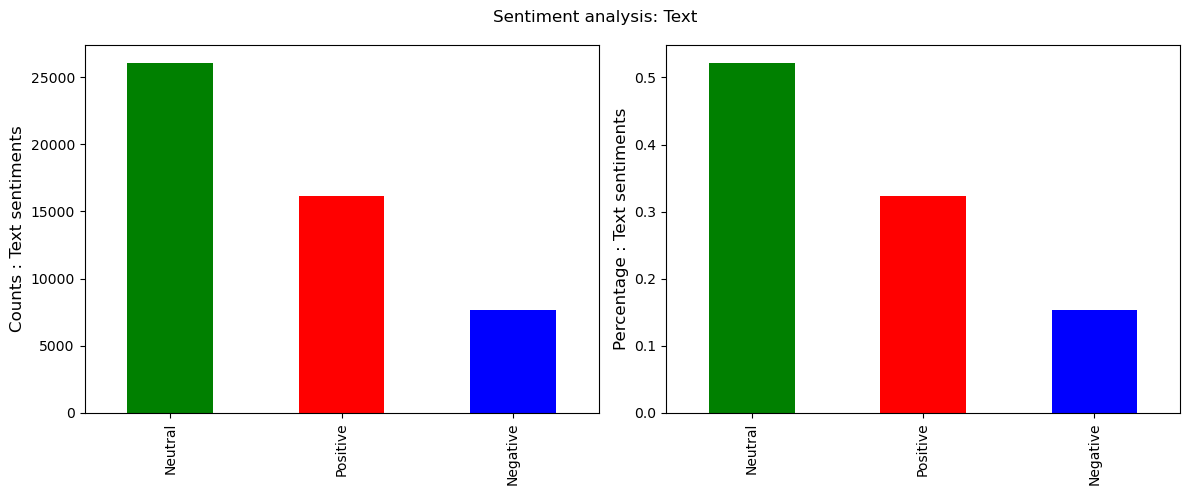

In [41]:
df['text_sentiment'] = df['Text'].apply(lambda x: find_sentiment(x))
plot_sentiment(df, 'text_sentiment', 'Text')

In [42]:
df = df[['Text', 'Language']]

In [43]:
df = df.dropna()

In [44]:
x_train = df['Text']
y_train = df['Language']

In [45]:
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()

In [46]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2)

In [47]:
tfidf = TfidfVectorizer()

x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_test)

APPLYING DECISION TREE IN PYTHON

In [48]:
 # Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(x_train_tfidf, y_train)

In [49]:
#Predict the response for test dataset
y_pred = clf.predict(x_test_tfidf)

In [50]:
print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred) * 100, 4), "%")

Accuracy: 86.7521 %


APPLYING RANDOM FOREST

In [51]:
# Create Random Forest classifer object
rf = RandomForestClassifier()

# Train Random Forest Classifer
rf.fit(x_train_tfidf, y_train)

RandomForestClassifier()

In [52]:
#Predict the response for test dataset
y_pred = rf.predict(x_test_tfidf)

In [53]:
print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred) * 100, 4), "%")

Accuracy: 92.4455 %


APPLYING KNN

In [54]:
# Create KNN classifer object
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=61) 

# Train KNN Classifer
knn.fit(x_train_tfidf, y_train)

KNeighborsClassifier(n_neighbors=61)

In [55]:
#Predict the response for test dataset
y_pred = knn.predict(x_test_tfidf)

AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred) * 100, 4), "%")